In [298]:
import sys
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
import matplotlib.pyplot as plt
from PySide6.QtWidgets import QApplication
from temgymbasic.gui import TemGymWindow

import numpy as np
from temgymbasic.utils import calculate_phi_0

from poke.beamlets import prop_complex_curvature, det_2x2, extra_factors, determine_misalingment_vectors, \
                          transversal_phase, guoy_phase
%matplotlib ipympl

In [299]:
def convert_slope_to_direction_cosines(dx, dy):
    l = dx / np.sqrt(1 + dx ** 2 + dy ** 2)
    m = dy / np.sqrt(1 + dx ** 2 + dy ** 2)
    n = 1 / np.sqrt(1 + dx** 2 + dy ** 2)
    return l, m, n

def differential_matrix(rayset, dPx, dPy, dHx, dHy):
    
    x_cen_T = rayset[0, 0, :]
    x_px_T = rayset[1, 0, :]
    x_py_T = rayset[2, 0, :]
    x_pl_T = rayset[3, 0, :]
    x_pm_T = rayset[4, 0, :]
    
    l_cen_T = rayset[0, 1, :]
    l_px_T = rayset[1, 1, :]
    l_py_T = rayset[2, 1, :]
    l_pl_T = rayset[3, 1, :]
    l_pm_T = rayset[4, 1, :]

    y_cen_T = rayset[0, 2, :]
    y_px_T = rayset[1, 2, :]
    y_py_T = rayset[2, 2, :]
    y_pl_T = rayset[3, 2, :]
    y_pm_T = rayset[4, 2, :]

    m_cen_T = rayset[0, 3, :]
    m_px_T = rayset[1, 3, :]
    m_py_T = rayset[2, 3, :]
    m_pl_T = rayset[3, 3, :]
    m_pm_T = rayset[4, 3, :]

    # Computing each element of the matrix
    ABCD = np.array([
        [(x_px_T - x_cen_T) / dPx, (x_py_T - x_cen_T) / dPy, (x_pl_T - x_cen_T) / dHx, (x_pm_T - x_cen_T) / dHy],
        [(y_px_T - y_cen_T) / dPx, (y_py_T - y_cen_T) / dPy, (y_pl_T - y_cen_T) / dHx, (y_pm_T - y_cen_T) / dHy],
        [(l_px_T - l_cen_T) / dPx, (l_py_T - l_cen_T) / dPy, (l_pl_T - l_cen_T) / dHx, (l_pm_T - l_cen_T) / dHy],
        [(m_px_T - m_cen_T) / dPx, (m_py_T - m_cen_T) / dPy, (m_pl_T - m_cen_T) / dHx, (m_pm_T - m_cen_T) / dHy]
    ])
    
    ABCD = ABCD.transpose(2, 0, 1)
    A = ABCD[:, 0:2, 0:2]
    B = ABCD[:, 0:2, 2:4]
    C = ABCD[:, 2:4, 0:2]
    D = ABCD[:, 2:4, 2:4]
    
    return A, B, C, D

def make_detector(dsize, npix, z_prop):
    x = np.linspace(-dsize/2,dsize/2,npix)
    x,y = np.meshgrid(x,x)

    return np.asarray([x.ravel(),y.ravel(),z_prop*np.ones_like(x.ravel())])

def evalmisaligned(r_ray_start, r_ray, k_ray_start, k_ray, opd, npix, dcoords, Amplitude, Qpinv, A, B, k):
    
    rho_1,the_1,rho_2,the_2 = determine_misalingment_vectors(r_ray_start[0],r_ray[0],k_ray_start[0],k_ray[0])
    field = np.zeros([dcoords.shape[1]], dtype=np.complex128)
    
    dcoords = np.moveaxis(dcoords,-1,0)

    detpixels = np.broadcast_to(dcoords,[Qpinv.shape[0],*dcoords.shape])
    detpixels = np.swapaxes(detpixels,0,1)
    detpixels = detpixels[...,:2]
    phi = 1j*k/2 * extra_factors(rho_1,detpixels,B,A)
    print(np.max(phi))

    transversal = -1j*k*transversal_phase(Qpinv,detpixels - np.broadcast_to(rho_2,[detpixels.shape[0],*rho_2.shape]))

    OPD = 1j*k*opd[0]
    OPD = np.broadcast_to(OPD,[detpixels.shape[0],*OPD.shape])
    guoy = -1j*guoy_phase(Qpinv)
    field += np.sum(Amplitude*np.exp(transversal + OPD + guoy + phi),-1)

    field = field.reshape(npix,npix)
    
    return field

In [300]:

wavelength = 0.001
deflection = -0.2
a = 0.5
b = 0.5
d = 2*a*deflection
spacing = ((a+b)/abs(d))*wavelength

npix = 101
det_shape = (npix, npix)
pixel_size = 0.001
dsize = det_shape[0] * pixel_size

wo = 0.01
div = wavelength / (np.pi * wo)

dPx = wo
dPy = wo
dHx = div
dHy = div

z_r = (np.pi * wo ** 2) / wavelength

In [301]:

components = (
    comp.GaussBeam(
        z=0.0,
        voltage=calculate_phi_0(wavelength),
        radius=0.01,
        wo=wo
    ),
    # comp.Biprism(
    #     z=a,
    #     offset=0.0,
    #     rotation=0.0,
    #     deflection=deflection,
    # ),
    comp.PerfectLens(
        z=a,
        f = b,
        m = -1,
    ),
    comp.AccumulatingDetector(
        z=a+b,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=64,
    ),
)

In [302]:
model = Model(components)
n_rays = 5
rays = tuple(model.run_iter(num_rays=n_rays))
image = model.detector.get_image(rays[-1])
det_x = np.linspace(-det_shape[1]//2*pixel_size, det_shape[1]//2*pixel_size, det_shape[1])

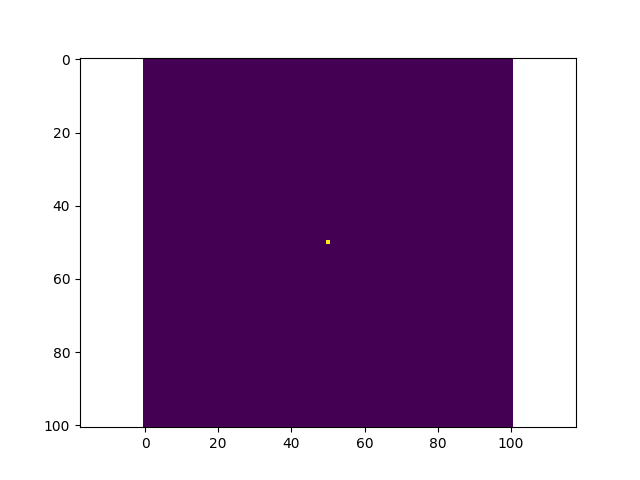

In [303]:
plt.axis('equal')
plt.imshow(np.abs(image)**2/np.max(np.abs(image)**2))
plt.show()

In [304]:
start_rays = rays[0].data[0:4, :].T
end_rays = rays[-1].data[0:4, :].T
path_length = rays[-1].path_length

# Split the array into two parts along the first axis
split_start_rays = np.split(start_rays, n_rays, axis=0)
split_end_rays = np.split(end_rays, n_rays, axis=0)
split_path_length = np.split(path_length, n_rays, axis=0)

# Stack the split arrays along a new axis
rayset0 = np.stack(split_start_rays, axis=-1)
rayset1 = np.stack(split_end_rays, axis=-1)
opd = np.stack(split_path_length, axis=-1)

In [305]:
# AppWindow = QApplication(sys.argv)
# viewer = TemGymWindow(model)
# viewer.show()
# AppWindow.exec()

In [306]:
A, B, C, D = differential_matrix(rayset1, dPx, dPy, dHx, dHy)
print(A.shape)

(5, 2, 2)


In [307]:
qinv = 1/(1j*z_r)
Qinv = np.asarray([[qinv,0],[0,qinv]])
Qinv = Qinv[np.newaxis]

Qpinv = prop_complex_curvature(Qinv,A,B,C,D)
Amplitude = 1/(np.sqrt(det_2x2(A + B @ Qpinv)))

In [308]:
z0 = np.zeros((5, n_rays))
z = np.zeros_like(z0)

z = z[:, np.newaxis, :]
zData = z[:, np.newaxis, :]
xData, yData = rayset1[:, np.newaxis, 0], rayset1[:, np.newaxis, 2]

n = (1 + rayset1[:, 1] ** 2 + rayset1[:, 3] ** 2)
nData = n[:, np.newaxis, :]
lData, mData = rayset1[:, np.newaxis, 1], rayset1[:, np.newaxis, 3]

xStart, yStart, zStart = rayset0[:, 0], rayset0[:, 2], 0.0 * zData[:, 0, 0]
lStart, mStart, nStart = rayset0[:, 1], rayset0[:, 3], 1 / (1 + rayset0[:, 1] ** 2 + rayset0[:, 3] ** 2)

xEnd, yEnd, zEnd = rayset1[:, 0], rayset1[:, 2], zData[:, 0, 0]
lEnd, mEnd, nEnd = rayset1[:, 1], rayset1[:, 3], 1 / (1 + rayset1[:, 1] ** 2 + rayset1[:, 3] ** 2)


In [309]:
from poke.beamlets import center_transversal_plane, orthogonal_transformation_matrix, distance_to_transversal, propagate_rays_and_transform, optical_path_and_delta
k = 2 * np.pi / wavelength

r_ray_start = np.moveaxis(np.asarray([xStart,yStart,zStart]),0,-1)
k_ray_start = np.moveaxis(np.asarray([lStart,mStart,nStart]),0,-1)
r_ray = np.moveaxis(np.asarray([xEnd,yEnd,zEnd]),0,-1)
k_ray = np.moveaxis(np.asarray([lEnd,mEnd,nEnd]),0,-1)

dcoords = make_detector(dsize, npix, z_prop = 0.0)
dnorm = np.array([[0., 0., 1.]])


In [310]:
field_misaligned = evalmisaligned(r_ray_start, r_ray, k_ray_start, k_ray, opd, npix, dcoords, Amplitude, Qpinv, A, B, k)

8.86400670666641j


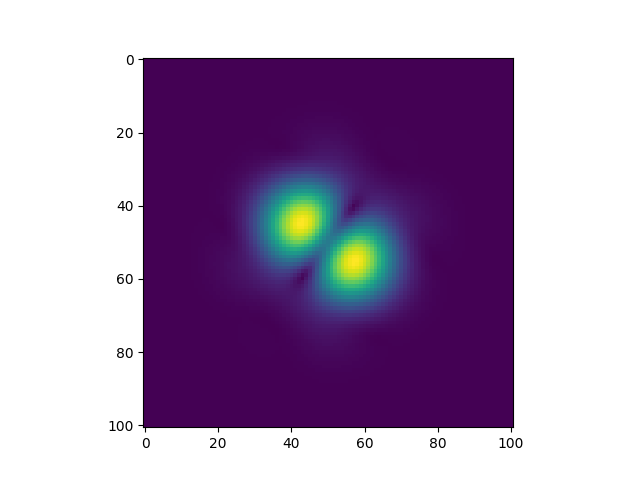

In [311]:
plt.figure()
plt.imshow(np.abs(field_misaligned))

In [312]:
O = orthogonal_transformation_matrix(k_ray[0],dnorm)
Delta = distance_to_transversal(dcoords,r_ray,k_ray)
r_ray,k_ray = propagate_rays_and_transform(r_ray,k_ray,Delta,O)
r = center_transversal_plane(dcoords, r_ray, O)

transversal = (r[...,0]*Qpinv[...,0,0] + r[...,1]*Qpinv[...,1,0])*r[...,0]
transversal = (transversal + (r[...,0]*Qpinv[...,0,1] + r[...,1]*Qpinv[...,1,1])*r[...,1])/2

opticalpath = -1j*k*optical_path_and_delta(opd,Delta)

field = np.zeros([dcoords.shape[1]],dtype=np.complex128)
field += np.sum(Amplitude*np.exp(transversal + opticalpath),axis=1)
field = field.reshape(npix,npix)

n shape =  (5, 3)
r shape =  (3, 10201)
n @ r shape (5, 5, 10201)


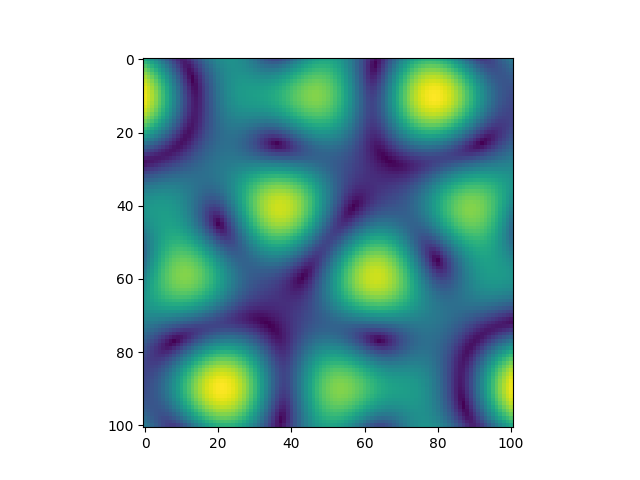

In [313]:
plt.figure()
plt.imshow(np.abs(field))